# tutorial on character-level classifier RNN (given a word, classify language)
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

In [3]:
!ls data/names

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

['data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt']


In [2]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("number of categories (languages): {}".format(n_categories))
print("average number of surnames per language: {}".format(int(sum([len(c) for c in category_lines.values()])/n_categories)))
print("total number of surnames: {}".format(sum([len(c) for c in category_lines.values()])))

number of categories (languages): 18
average number of surnames per language: 1115
total number of surnames: 20074


Now that we have all the names organized, we need to turn them into Tensors to make any use of them.
To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>. Each word will be a 2d tensor of shape (n_letters, 52), being 52 the number of different letters in out dataset.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

/home/bcl/.conda/envs/pytorch13/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
print("RNN hidden size: {}".format(n_hidden))
rnn = RNN(n_letters, n_hidden, n_categories)
#        input_size, hidden,    output_size

RNN hidden size: 128


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step)

In [5]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8656, -2.8609, -2.9322, -2.8480, -2.9052, -2.9052, -2.9839, -2.8799,
         -2.7801, -2.8298, -2.9608, -3.0025, -2.9097, -2.9065, -2.8897, -2.9266,
         -2.8602, -2.8086]], grad_fn=<LogSoftmaxBackward0>)


In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 8)


In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Soma
category = Chinese / line = Gauk
category = Vietnamese / line = Mach
category = Arabic / line = Issa
category = Scottish / line = Mcintosh
category = Chinese / line = Bui
category = Portuguese / line = Machado
category = Russian / line = Rakhmanin
category = German / line = Carver
category = Scottish / line = Hill


In [8]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [9]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 3.2536 Gajos / Greek ✗ (Polish)
10000 10% (0m 10s) 2.0901 Pierre / French ✓
15000 15% (0m 14s) 1.4413 Moon / Korean ✓
20000 20% (0m 17s) 2.4290 Docherty / Italian ✗ (Scottish)
25000 25% (0m 20s) 3.4554 Tron / Scottish ✗ (Vietnamese)
30000 30% (0m 24s) 2.1372 Harb / German ✗ (Arabic)
35000 35% (0m 27s) 3.8255 Huang / Japanese ✗ (Chinese)
40000 40% (0m 32s) 2.2831 Fuchs / Portuguese ✗ (German)
45000 45% (0m 36s) 3.5857 Shanks / Czech ✗ (English)
50000 50% (0m 40s) 0.0951 Thach / Vietnamese ✓
55000 55% (0m 43s) 1.0927 Trucco / Italian ✓
60000 60% (0m 47s) 3.0812 Hughes / Dutch ✗ (Scottish)
65000 65% (0m 51s) 4.7702 Samson / Arabic ✗ (French)
70000 70% (0m 54s) 0.3208 Chou / Korean ✓
75000 75% (0m 58s) 0.1119 Wyrzyk / Polish ✓
80000 80% (1m 4s) 1.8962 Gehrig / German ✓
85000 85% (1m 8s) 0.3670 Motoyoshi / Japanese ✓
90000 90% (1m 11s) 1.6988 Salomon / French ✗ (Polish)
95000 95% (1m 14s) 2.0006 Sokolofsky / Russian ✗ (Polish)
100000 100% (1m 20s) 0.2750 Hanraets / Dutch ✓


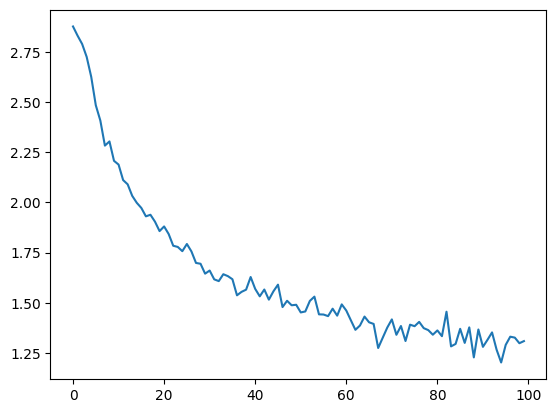

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_1672022/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1672022/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


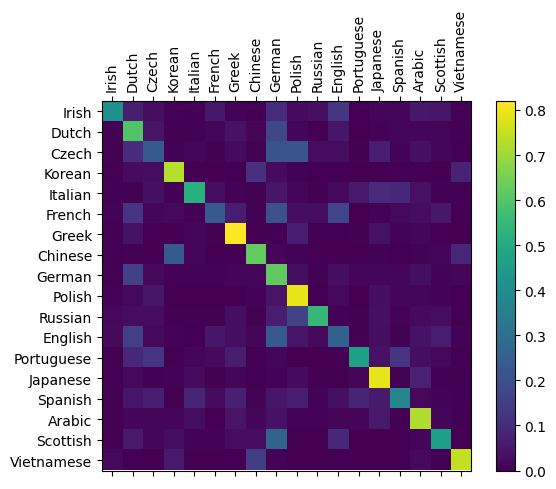

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [37]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Torre')


> Torre
(-1.42) French
(-1.68) Dutch
(-1.89) English
